## Predictive modeling of future customer demand trends

In [1]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
from pandas import DataFrame
from pandas import concat
import numpy as np
from math import sqrt

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import boxcox

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from matplotlib import colors
%matplotlib inline

In [2]:
df = '/Users/sseyeoni/Documents/jupyter/Cintas/Results/MBAinfo_Retail_Clean_update.xlsx'
df = pd.read_excel(df)

df.head()

,Material,Year/Period,Retail_sales
0,110,2020-04-01,183175
1,111,2020-04-01,243
2,112,2020-04-01,2096
3,113,2020-04-01,1673
4,120,2020-04-01,178781


In [3]:
df = df.rename(columns={'Year/Period':'Date', 'Retail_sales':'Retail_Value'})

In [4]:
# retail value grouped by each date
gdf = df.groupby('Date')['Retail_Value'].sum()
gdf = gdf.reset_index()
gdf.head()

,Date,Retail_Value
0,2020-04-01,5025720
1,2020-05-01,4506589
2,2020-06-01,5033024
3,2020-07-01,5858837
4,2020-08-01,5678156


In [5]:
gdf.Date = pd.to_datetime(gdf.Date)

gdf = gdf.set_index("Date")
gdf.head()

,Retail_Value
Date,
2020-04-01,5025720
2020-05-01,4506589
2020-06-01,5033024
2020-07-01,5858837
2020-08-01,5678156


In [7]:
gdf.tail()

,Retail_Value
Date,
2022-11-01,6089256
2022-12-01,6002201
2023-01-01,6216336
2023-02-01,5874160
2023-03-01,6842284


### Rolling Statistics

<AxesSubplot: xlabel='Date'>

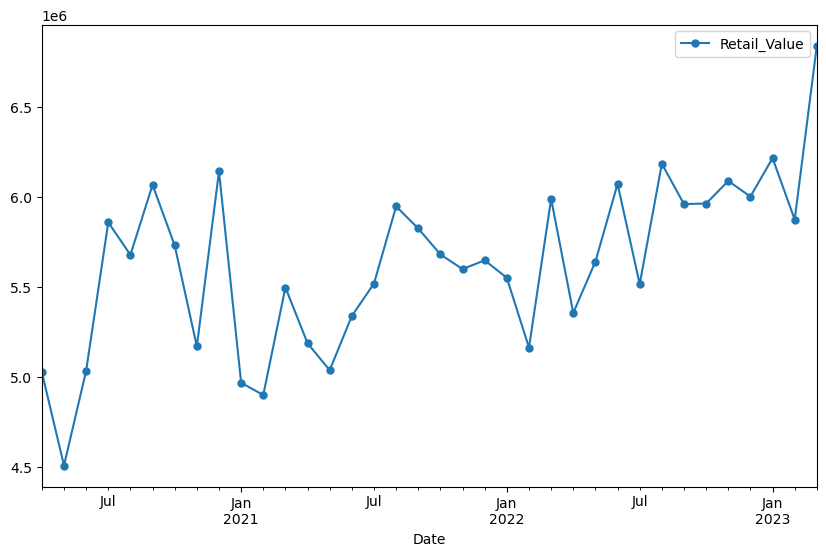

In [8]:
gdf['Retail_Value'].plot(figsize = (10,6), legend=True, marker='o', markersize=5)

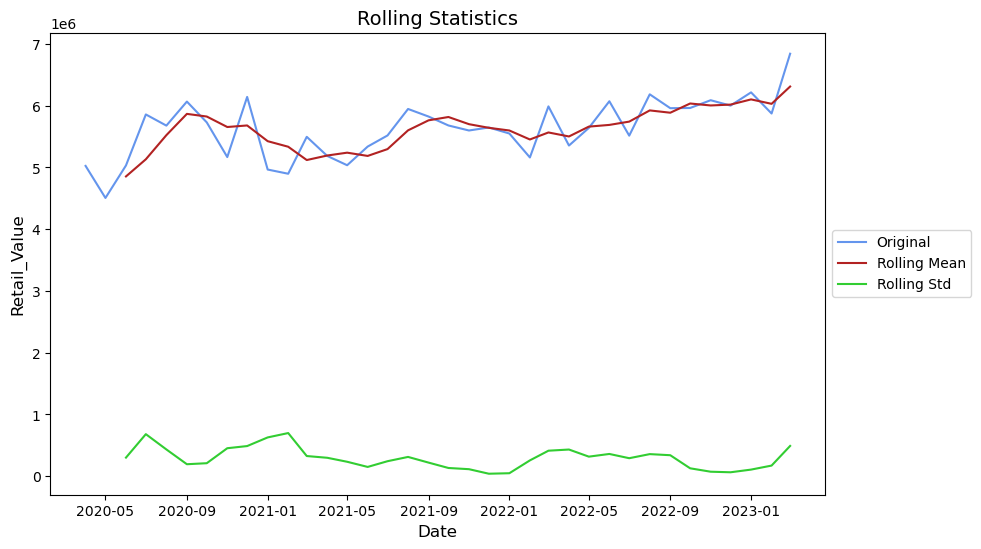

In [9]:
rolling_mean = gdf.rolling(window=3).mean()
rolling_std = gdf.rolling(window=3).std()

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(gdf, color='cornflowerblue', label='Original')
ax.plot(rolling_mean, color='firebrick', label='Rolling Mean')
ax.plot(rolling_std, color='limegreen', label='Rolling Std')

ax.set_xlabel('Date', size=12)
ax.set_ylabel('Retail_Value', size=12)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('Rolling Statistics', size=14)

plt.show()

### Acf (Autocorrelation)

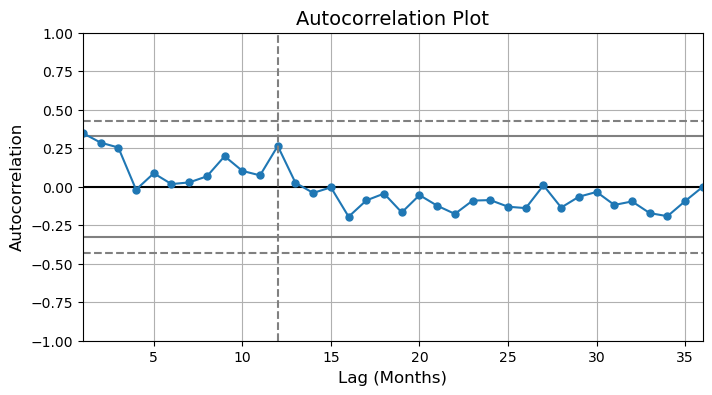

In [10]:
import matplotlib.pyplot as plt
from importlib import reload
plt=reload(plt)

plt.figure(figsize=(8, 4))
pd.plotting.autocorrelation_plot(gdf['Retail_Value'], marker='o', markersize=5)
plt.axvline(x=12, linestyle='--', color='grey')
plt.xlabel('Lag (Months)', fontsize=12)  # explicitly reference the xlabel function from matplotlib.pyplot
plt.ylabel('Autocorrelation', fontsize=12)
plt.title('Autocorrelation Plot', fontsize=14)
plt.show()

### Pacf (Partial Autocorrelation)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 800x400 with 0 Axes>

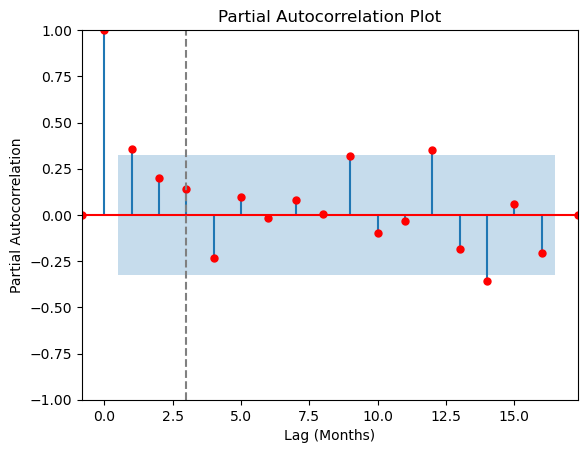

In [11]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt
from importlib import reload
plt=reload(plt)
# assume gdf is a pandas DataFrame containing the time series data

plt.figure(figsize=(8, 4))
plot_pacf(gdf['Retail_Value'], lags=16, marker='o', markersize=5, color='red')
plt.axvline(x=3, linestyle='--', color='grey')
plt.xlabel('Lag (Months)')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Plot')
plt.show()

### Decomposition

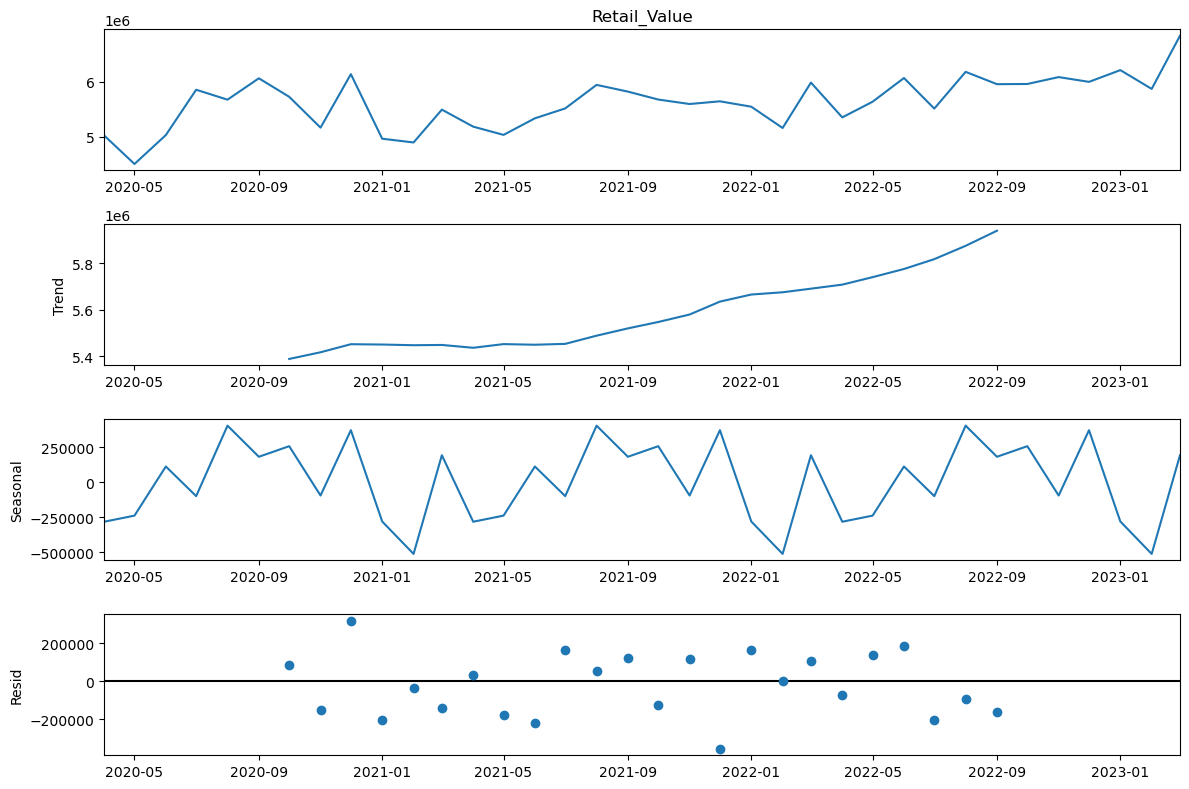

In [12]:
rcParams['figure.figsize'] = 12, 8
dec = seasonal_decompose(gdf["Retail_Value"], model = "add")
dec.plot();

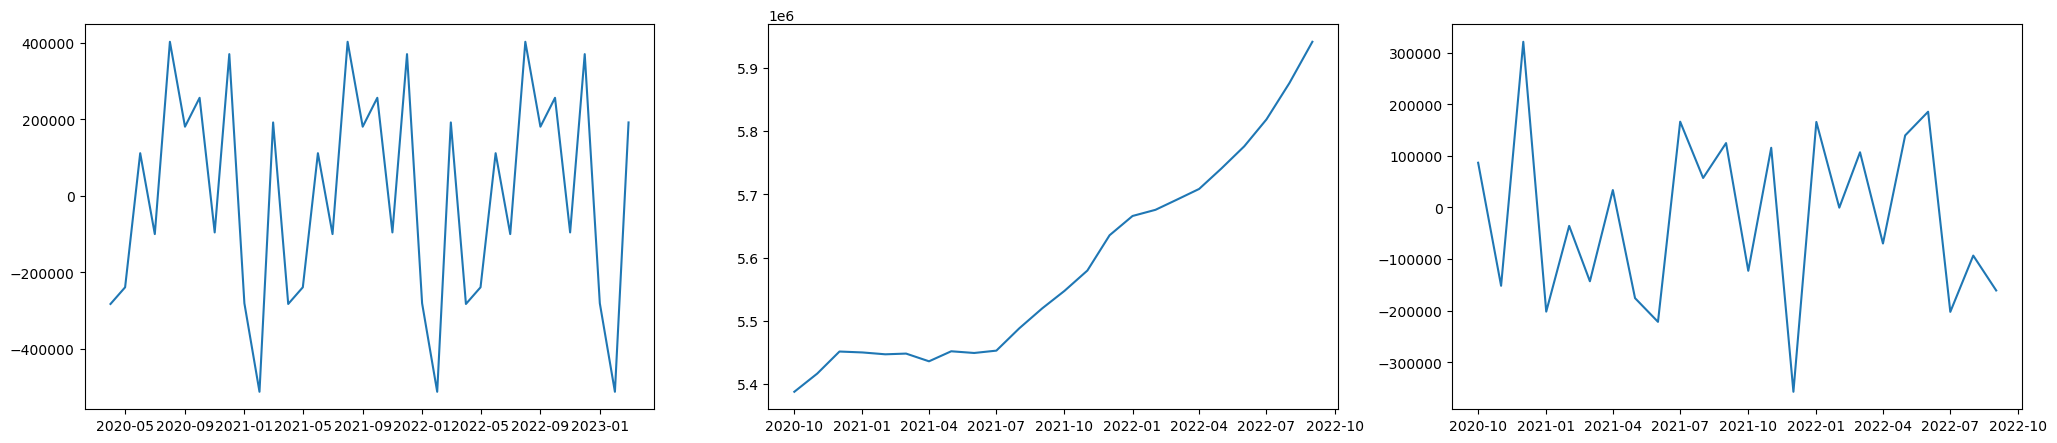

In [13]:
plt.figure(figsize = (25, 5))
a = seasonal_decompose(gdf["Retail_Value"], model = "add")
plt.subplot(1, 3, 1)
plt.plot(dec.seasonal)

plt.subplot(1, 3, 2)
plt.plot(dec.trend)

plt.subplot(1, 3, 3)
plt.plot(dec.resid)

plt.show()

In [14]:
# check for stationarity using the Augmented Dickey-Fuller test
result = adfuller(gdf['Retail_Value'])
print('ADF Statistic: {:.3f}'.format(result[0]))
print('p-value: {:.3f}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {:.3f}'.format(key, value))

ADF Statistic: -1.855
p-value: 0.354
Critical Values:
	1%: -3.646
	5%: -2.954
	10%: -2.616


## Forecasting Model

**ARIMA Model** stands for Auto-Regressive Integrated Moving Average.<br> It is is used for predicting future trends on a time series data. It is model that form of regression analysis.

**Auto-Regressive** models predict future behavior using past behavior where there is some correlation between past and future data.

**Integration** is the difference between present and previous observations. It is used to make the time series stationary.

**Moving Average** is a statistical method that takes the updated average of values to help cut down on noise. It takes the average over a specific interval of time

**p**: Value just before convergence in pacf. ( =3 )<br>
**d** : Check whether there is a trend by adf test and visual confirmation of the trend ( =0 )<br>
**q** : value just before convergence in acf ( =1)<br>
**P** : Check how many times the seasonality cycle was repeated in the pacf ( =0 )<br>
**D**: Check whether there is seasonality, 1 or 0 ( =0 ) depending on the need for seasonality difference <br>
**Q**: Check how many times the seasonal cycle based on acf has been repeated (=1)<br>
**m** : seasonal period ( =12 )

In [15]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

train_data = gdf[:len(gdf)-12]
test_data = gdf[len(gdf)-12:]

arima_model = SARIMAX(gdf['Retail_Value'], order = (3,0,1), seasonal_order = (0,0,1,12))
arima_result = arima_model.fit()
arima_result.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.33072D+02    |proj g|=  2.33160D+02

At iterate    5    f=  1.44493D+01    |proj g|=  3.76101D-01

At iterate   10    f=  1.42624D+01    |proj g|=  1.93532D-02

At iterate   15    f=  1.42513D+01    |proj g|=  1.16283D-02

At iterate   20    f=  1.42509D+01    |proj g|=  4.00354D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     23      1     0     0   4.018D-06   1.425D+01
  F =   14.250860516143295     

CONVERG

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       Retail_Value   No. Observations:                   36
Model:             SARIMAX(3, 0, 1)x(0, 0, 1, 12)   Log Likelihood                -513.031
Date:                            Tue, 25 Apr 2023   AIC                           1038.062
Time:                                    16:51:58   BIC                           1047.563
Sample:                                04-01-2020   HQIC                          1041.378
                                     - 03-01-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2030      0.475     -0.428      0.669      -1.133       0.727
ar.L2          0.5727      0.320      1.790      0.073      -0.054       1.200
ar.L3          0.6257      0.275      2.277      0.023       0.087       1.164
ma.L1          0.6059      0.602      1.007      0.314      -0.574       1.786
ma.S.L12       0.5902      0.383      1.540      0.123      -0.161       1.341
sigma2      1.372e+11    2.8e-12   4.91e+22      0.000    1.37e+11    1.37e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):                 0.04
Prob(Q):                              0.64   Prob(JB):                         0.98
Heteroskedasticity (H):               0.27   Skew:                             0.05
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.46e+38. Standard errors may be unstable.
"""

In [16]:
arima_pred = arima_result.predict(start = len(train_data), end = len(gdf)-1, typ="levels").rename("ARIMA Predictions")
arima_pred

2022-04-01    5.649065e+06
2022-05-01    5.368785e+06
2022-06-01    5.790361e+06
2022-07-01    5.500698e+06
2022-08-01    6.089983e+06
2022-09-01    5.879536e+06
2022-10-01    5.824296e+06
2022-11-01    6.163570e+06
2022-12-01    5.771348e+06
2023-01-01    6.191708e+06
2023-02-01    5.960830e+06
2023-03-01    6.286080e+06
Freq: MS, Name: ARIMA Predictions, dtype: float64

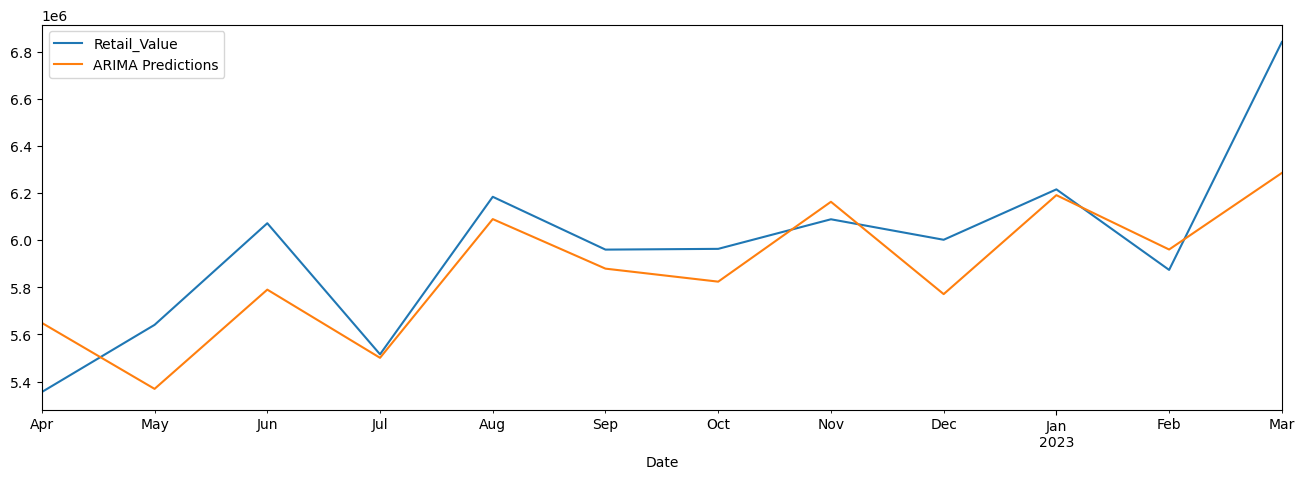

In [17]:
test_data['Retail_Value'].plot(figsize = (16,5), legend=True)
arima_pred.plot(legend = True);

In [18]:
from statsmodels.tools.eval_measures import rmse

arima_rmse_error = rmse(test_data['Retail_Value'], arima_pred)
arima_mse_error = arima_rmse_error**2
mean_value = gdf['Retail_Value'].mean()

print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}\nMean: {mean_value}')

MSE Error: 54266892090.67662
RMSE Error: 232952.5533036215
Mean: 5632571.611111111


In [19]:
arima_pred_f = arima_result.predict(start = len(gdf), end = len(gdf)+12, typ="levels").rename("ARIMA Predictions")
arima_pred_f

2023-04-01    6.206797e+06
2023-05-01    6.385583e+06
2023-06-01    6.788457e+06
2023-07-01    6.268379e+06
2023-08-01    6.670242e+06
2023-09-01    6.562554e+06
2023-10-01    6.518141e+06
2023-11-01    6.614320e+06
2023-12-01    6.603091e+06
2024-01-01    6.620696e+06
2024-02-01    6.534554e+06
2024-03-01    6.886068e+06
2024-04-01    6.680834e+06
Freq: MS, Name: ARIMA Predictions, dtype: float64

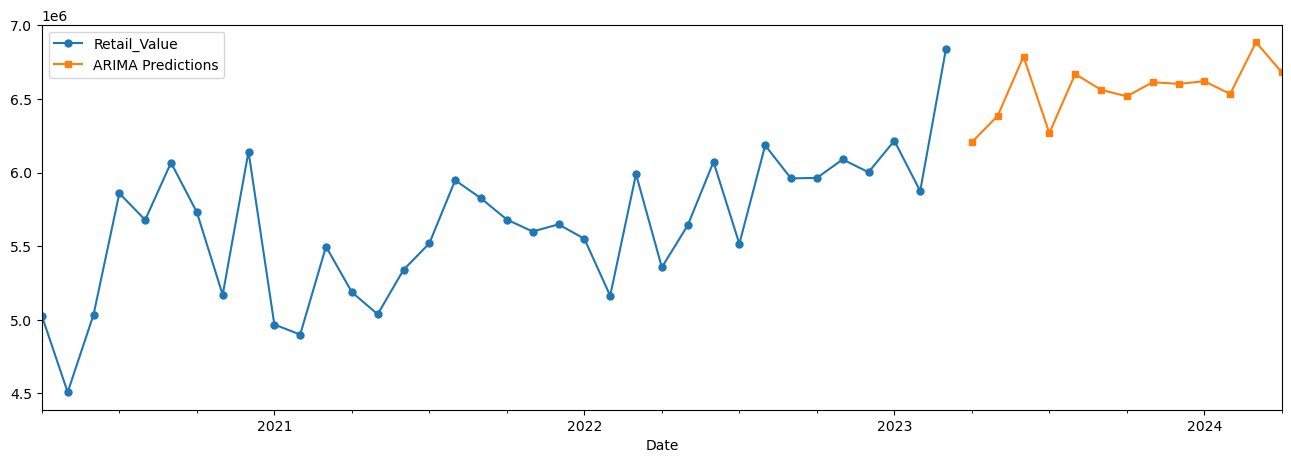

In [20]:
gdf['Retail_Value'].plot(figsize = (16,5), legend=True, marker='o', markersize=5)
arima_pred_f.plot(legend = True, marker='s', markersize=5);

In [21]:
pdf = arima_pred_f.to_frame(name='Retail_Value')
pdf.head()

,Retail_Value
2023-04-01,6.206797e+06
2023-05-01,6.385583e+06
2023-06-01,6.788457e+06
2023-07-01,6.268379e+06
2023-08-01,6.670242e+06


In [22]:
udf = pd.concat([gdf, pdf])

udf.reset_index(inplace=True)
udf = udf.rename(columns = {'index':'Date'})

In [23]:
udf.head()

,Date,Retail_Value
0,2020-04-01,5025720.0
1,2020-05-01,4506589.0
2,2020-06-01,5033024.0
3,2020-07-01,5858837.0
4,2020-08-01,5678156.0


In [24]:
udf.to_csv('/Users/sseyeoni/Documents/jupyter/Cintas/Forecasting/Results/Retail_Predictive_Model.csv', index=False)